# 3DeeCellTracker Demo

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import warnings
warnings.filterwarnings('ignore')
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage.measurements as snm
from scipy.stats import trim_mean
import tensorflow as tf
from keras.backend import tensorflow_backend
from keras.models import load_model
from PIL import Image
from skimage.segmentation import relabel_sequential
from skimage.measure import label
import matplotlib as mpl
mpl.rcParams['image.interpolation']='none'

from CellTracker.unet3d import unet3_b, unet3_prediction
from CellTracker.watershed import watershed_2d_markers
from CellTracker.tracker import make_folders, segmentation, save_img3, displacement_image_to_real, \
    read_segmentation, interpolate, save_img3ts, get_subregions, match, track_one_vol

%matplotlib inline


Using TensorFlow backend.


# ++ Set the Global parameters ++

In [2]:
# parameters according to imaging conditions
par_image = {"volume_num": 80,  # number of volumes the 3D + T image
             "x_siz": 168,  # size of each 3D image
             "y_siz": 401,  # size of each 3D image
             "z_siz": 128,  # size of each 3D image
             # the (rough) resolution ratio between the z axis and the x-y plane
             "z_xy_ratio": 1,
             # (integer; >=1) for interpolating images along z. z_scaling = 1 makes no interpolation.
             "z_scaling": 1,
             # <(input sizes of u-net)/2, pad and shrink for u-net prediction
             "shrink": (24, 24, 2),
             "miss_frame": [79]  # frames that cannot be processed
             }

# parameters manually determined by experience
par_tracker = {"noise_level": 200,  # a threshold to discriminate noise/artifacts from cells
               "min_size":400,  # a threshold to remove small objects which may be noise/artifacts
               "BETA": 1000,  # control coherence using a weighted average of movements of nearby points;
               # larger BETA includes more points, thus generates more coherent movements
               "LAMBDA": 0.00001,  # control coherence by adding a loss of incoherence, large LAMBDA
               # generates larger penalty for incoherence.
               "max_iteration": 10, # maximum number of iterations; large values generate more accurate tracking.
               "ensemble": 20,  # use ensemble mode (False: single mode; value: number of predictions to make)
               "adjacent": False  # irrelevant in single mode
               }

# parameters of paths/names
par_path = {"folder_path": os.path.abspath("./worm4"),  # path of the folder storing related files
            "files_name": "raw_t%04i_z%04i.tif",  # file names for the raw image files
            # file names for the manaul segmentation files at t=1
            "manual_name": "manual_labels%04i.tif",
            # weight file of the trained 3D U-Net. f2b:structure a; fS2a:b; fS2b:c
            "unet_weight_file": "unet3_fS2a_Leifer_0.0086.hdf5",
            "FFN_weight_file": "FFN_model.h5"  # weight file of the trained FFN model
            }

# Make folders for data, models, result, etc.
make_folders(par_path, par_tracker["ensemble"], par_tracker["adjacent"])

# load 3D unet model
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)
unet_model = unet3_b()
unet_model.load_weights(os.path.join(
    par_path["models_path"], par_path["unet_weight_file"]))

# ++ Add data and model files to the folders before going to the next step ++

# Generate automatic segmetation of volume 1

segmentation took 5.0 s
Left: cell regions at t=1 by U-Net; Right: auto-segmentation at t=1


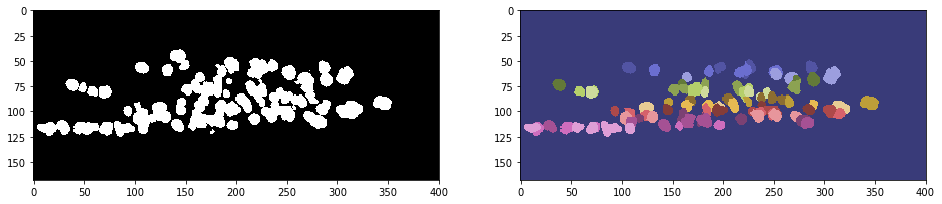

In [3]:
# segment 3D image of volume #1
volume = 1
image_cell_bg, l_center_coordinates, segmentation_auto, image_gcn = \
    segmentation(1, par_image, par_tracker, par_path,
                 unet_model, method="min_size", neuron_num=0)
# save the segmented cells of volume #1
save_img3(z_siz_=par_image["z_siz"], img=segmentation_auto,
          path=par_path["auto_segmentation_vol1_path"] + "auto_t%04i_z%04i.tif")
# transform the coordinate from voxel scale to real scale
r_coordinates_segment_pre = displacement_image_to_real(
    l_center_coordinates, par_image)

# draw predicted cell regions and segmentation at t=1 (2D projection)
print("Left: cell regions at t=1 by U-Net; Right: auto-segmentation at t=1")
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
fig = plt.imshow(
    np.max(image_cell_bg[0, :, :, :, 0], axis=2) > 0.5, cmap="gray")
plt.subplot(1, 2, 2)
fig = plt.imshow(np.max(segmentation_auto, axis=2), cmap="tab20b")

# ++ Make manual segmentation based on the autosegmentation at t=1 ++

# Load manually corrected segmentation of volume 1 and interpolate it 

interpolating...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 
 manual segmentation at t=1


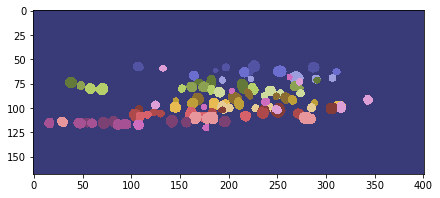

In [4]:
# load manually corrected segmentation
segmentation_manual = read_segmentation(par_path["manual_segmentation_vol1_path"],
                                        par_path["manual_name"], [0, par_image["z_siz"]])
# relabel cells sequentially
segmentation_manual_relabels, fw, inv = relabel_sequential(segmentation_manual)

# interpolate layers in z axis
seg_cells_interpolated_corrected = interpolate(
    par_image, segmentation_manual_relabels)

# save labels in the first volume (interpolated)
save_img3ts(range((par_image["z_scaling"] + 1) // 2,
                  seg_cells_interpolated_corrected.shape[2] + 1,
                  par_image["z_scaling"]),
            seg_cells_interpolated_corrected,
            par_path["track_results_path"] + "track_results_t%04i_z%04i.tif", 1)

# calculate coordinates of cell centers at t=1
center_points_t1 = snm.center_of_mass(segmentation_manual_relabels > 0, segmentation_manual_relabels,
                                      range(1, segmentation_manual_relabels.max()+1))
r_coordinates_tracked_pre = displacement_image_to_real(
    center_points_t1, par_image)

# save a copy of the coordinates in volume 1
r_coordinates_tracked_pre_vol1 = r_coordinates_tracked_pre.copy()

# draw interpolated manual segmantation
print("\n manual segmentation at t=1")
plt.figure(figsize=(7, 4))
fig = plt.imshow(
    np.max(seg_cells_interpolated_corrected, axis=2), cmap="tab20b")

# Prepare for tracking

In [5]:
# Compute subregions of each cells for quick "accurate correction"
seg_16 = seg_cells_interpolated_corrected.astype("int16")

region_list, region_width, region_xyz_min = get_subregions(
    seg_16, seg_16.max())
pad_x, pad_y, pad_z = np.max(region_width, axis=0)
label_padding = np.pad(seg_16, pad_width=((pad_x, pad_x), (pad_y, pad_y),
                                          (pad_z, pad_z)), mode='constant')*0

par_subregions = {"region_list": region_list,
                  "region_width": region_width,
                  "region_xyz_min": region_xyz_min,
                  "pad_x": pad_x,
                  "pad_y": pad_y,
                  "pad_z": pad_z,
                  "label_padding": label_padding
                  }
# test if there are multiple cells marked as a single region
for i, region in enumerate(region_list):
    if np.sum(np.unique(label(region))) > 1:
        print("more than one cell in region ", i+1)

# load FFN model
FFN_model = load_model(os.path.join(
    par_path["models_path"], par_path["FFN_weight_file"]))
# initialize all variables
r_displacement_from_vol1 = r_coordinates_tracked_pre*0
cells_on_boundary = r_displacement_from_vol1[:, 0].astype(int)
r_displacements = []
r_segmented_coordinates = []
r_segmented_coordinates.append(r_coordinates_segment_pre)
r_tracked_coordinates = []
r_tracked_coordinates.append(r_coordinates_tracked_pre)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 WARNING:tensorflow:From /home/wen/anaconda3/envs/3DCT/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Test FFN + PR-GLS + Accurate correction between current volume (vol1) and another volume (using single mode)

t=21
segmentation took 4.6 s
fnn + pr-gls took 2.1 s
cells on boundary: []
FFN + PR-GLS: Left: x-y; Right: x-z


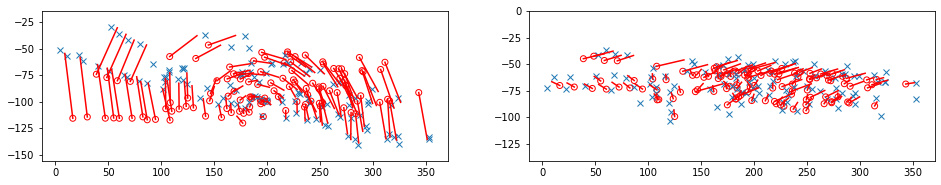

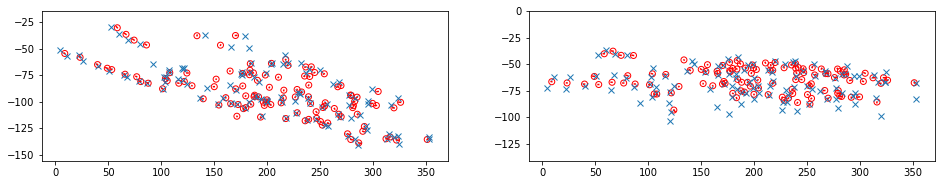

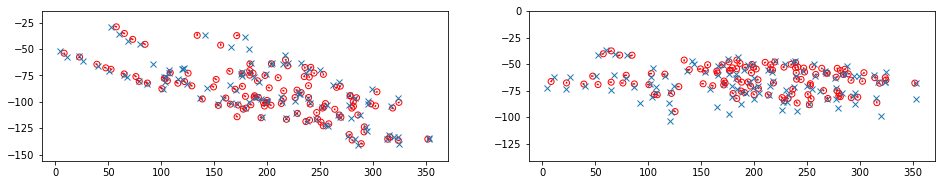

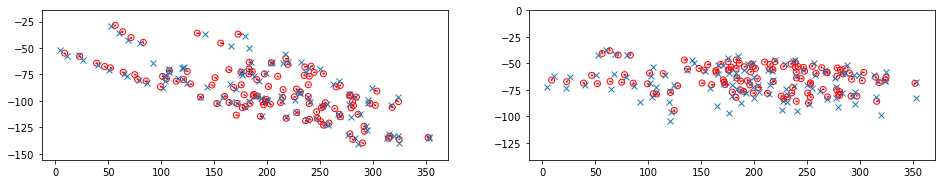

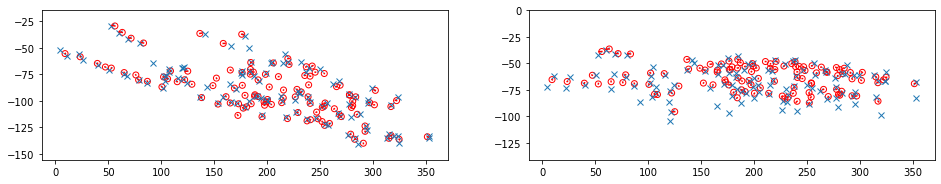

Accurate correction:
max correction: 2.484176186186005,1.71845937499819,0.866895906980659,0.6201017536741418,0.4976454384906219


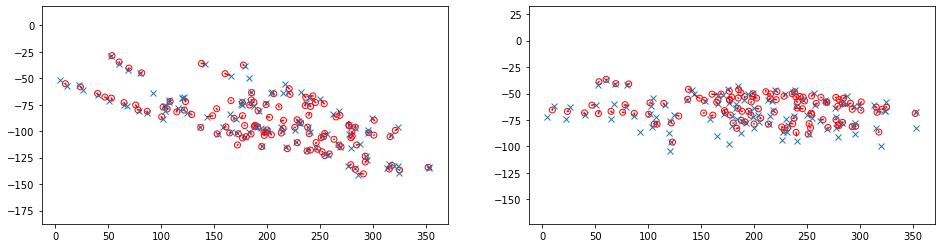

current volume: t= 1


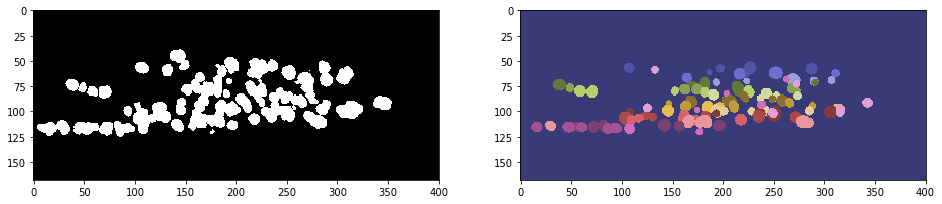

target volume: t= 21


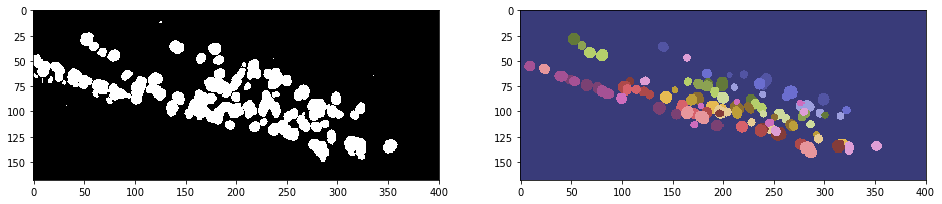

In [6]:
volume_test = 21
match(volume, volume_test, par_image, par_tracker, par_path, par_subregions, r_coordinates_segment_pre,
             r_coordinates_tracked_pre, r_coordinates_tracked_pre_vol1, cells_on_boundary, unet_model,
             FFN_model, r_displacement_from_vol1, seg_cells_interpolated_corrected,
             np.max(image_cell_bg[0, :, :, :, 0], axis=2) > 0.5,
             np.max(seg_cells_interpolated_corrected, axis=2), method="neuron_num")

# Tracking following volumes

In [8]:
def save_tracking_info(r_coordinates_segment_pre, r_coordinates_tracked_pre, r_displacement_from_vol1):
    r_displacements.append(r_displacement_from_vol1)
    r_segmented_coordinates.append(r_coordinates_segment_pre)
    r_tracked_coordinates.append(r_coordinates_tracked_pre)


t_1 = time.time()
for volume in range(2, par_image["volume_num"] + 1):
    print('t=%i' % volume)

    # skip frames that cannot be tracked
    if volume in par_image["miss_frame"]:
        save_tracking_info(r_coordinates_segment_pre,
                           r_coordinates_tracked_pre, r_displacement_from_vol1)
        save_img3ts(range(1, par_image["z_siz"] + 1), l_label_T_watershed,
                    par_path["track_results_path"] + "track_results_t%04i_z%04i.tif", volume)
        continue

    # track cells and save the results
    l_label_T_watershed, r_coordinates_segment_pre, r_coordinates_tracked_pre, r_displacement_from_vol1 = \
        track_one_vol(volume, par_image, par_tracker, par_path, par_subregions, unet_model, FFN_model,
                      r_segmented_coordinates, r_tracked_coordinates, r_displacement_from_vol1,
                      r_coordinates_tracked_pre_vol1, seg_cells_interpolated_corrected, cells_on_boundary,
                      method="neuron_num")

    # save tracking information
    save_tracking_info(r_coordinates_segment_pre,
                       r_coordinates_tracked_pre, r_displacement_from_vol1)

print('tracking all volumes took %.1f s' % (time.time() - t_1))

t=2
segmentation took 4.6 s
ref: 1, len of ref:1
fnn + pr-gls took 0.5 s
cells on boundary: []
max correction: 1.8196859304414374,1.078501981482006,0.7483066488078407,0.49947833457972024
accurate correction of displacement took 2.1 s
t=3
segmentation took 4.6 s
ref: 1, 2, len of ref:2
fnn + pr-gls took 1.1 s
cells on boundary: []
max correction: 2.3102793294762307,1.8196099340739522,1.1826060783369883,0.8836771604002109,0.49921048045681715
accurate correction of displacement took 2.6 s
t=4
segmentation took 4.6 s
ref: 1, 2, 3, len of ref:3
fnn + pr-gls took 1.6 s
cells on boundary: []
max correction: 2.350168903874689,1.7078151922157474,0.8000166775053685,0.49790563771549046
accurate correction of displacement took 2.1 s
t=5
segmentation took 4.6 s
ref: 1, 2, 3, 4, len of ref:4
fnn + pr-gls took 2.1 s
cells on boundary: []
max correction: 3.1348092143375084,2.143454496908305,1.244725655054026,1.0810565333245705,1.1228968807984288,0.7718337803929671,0.8382233799361742,0.6818523199546007

max correction: 2.0207273266277213,2.4176420815125326,1.707031988767973,1.2233296354221963,1.3865680691610365,1.25450714921827,0.7454050661257909,0.5326176091652286,0.6700827981659572,0.49748490425616865
accurate correction of displacement took 5.1 s
t=29
segmentation took 4.6 s
ref: 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, len of ref:20
fnn + pr-gls took 9.8 s
cells on boundary: []
max correction: 2.2411384602513778,2.3425316859602887,1.6567799457844856,1.5103080310109505,1.2011206864558588,0.8065512005983067,0.5240948434135575,0.5053573743868753,0.4984899750606502
accurate correction of displacement took 4.6 s
t=30
segmentation took 4.6 s
ref: 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, len of ref:20
fnn + pr-gls took 9.9 s
cells on boundary: []
max correction: 1.750194971508904,1.1044456249618868,1.0778382730765959,0.8939722147591613,0.6466315872264392,0.4969674821886443
accurate correction of displacement too

max correction: 4.091571387981475,2.0694189527366618,1.6386367235894994,2.8665895965841273,2.356171577343403,1.5709120388341802,0.6105143039405618,0.6581038089072706,0.7972251285551977,0.49114020158930316
accurate correction of displacement took 5.2 s
t=50
segmentation took 4.6 s
ref: 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, len of ref:20
fnn + pr-gls took 9.8 s
cells on boundary: []
max correction: 3.175860270522122,1.7616558160913485,0.9925966646102609,0.8272200302067745,0.5588714452950825,0.6169441018790494,0.5467212439344848,0.4991818793313598
accurate correction of displacement took 4.2 s
t=51
segmentation took 4.6 s
ref: 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, len of ref:20
fnn + pr-gls took 9.6 s
cells on boundary: []
max correction: 3.095971485790102,1.6518425814579842,1.00481789991386,0.8675999151879097,0.7259629280065525,0.49771428272823925
accurate correction of displacement took 3.1 s
t=52
segmen

max correction: 2.579638866046487,1.8583791699869323,2.450092271179784,1.9470445867766415,1.1364434852081757,1.0573873112236356,1.1168808685822995,1.0927753266169589,0.677940863547704,0.5539655856368881,0.5658532294798988,0.7224696608360688,0.4918737612127302
accurate correction of displacement took 6.8 s
t=70
segmentation took 4.6 s
ref: 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67, len of ref:20
fnn + pr-gls took 9.7 s
cells on boundary: []
max correction: 3.0685366436958645,1.5432548371434223,1.3802754352765092,0.9724935247706483,1.2358079492328642,1.475566113792766,1.4492196725249045,1.405402320395254,0.8860926092518753,0.4996898138159054
accurate correction of displacement took 5.2 s
t=71
segmentation took 4.6 s
ref: 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65, 68, len of ref:20
fnn + pr-gls took 9.6 s
cells on boundary: []
max correction: 2.864609377918498,1.70521394905127,1.2422950249628997,1.183714452359311,0.9711

In [9]:
np.save(par_path["track_information_path"]+"r_displacements.npy",r_displacements)
np.save(par_path["track_information_path"]+"r_tracked_coordinates.npy",r_tracked_coordinates)
np.save(par_path["track_information_path"]+"r_segmented_coordinates.npy",r_segmented_coordinates)